# 1. Get the Data

The data will be downloaded using [Kaggle's API](https://github.com/Kaggle/kaggle-api#api-credentials). For your own use, you will need to create a API key in **Account Settings**. On windows, you shoudl create the folder `.kaggle` inside your user and add the file `kaggle.json` donwloaded from the API.

After this, you can install and use the API.

In [1]:
!pip install kaggle

We can list all competitions.

In [2]:
!kaggle competitions list

502 - Bad Gateway


Check our especific competition data, in this case: **titanic**.

In [3]:
!kaggle competitions files -c titanic

name                   size  creationDate         
---------------------  ----  -------------------  
train.csv              60KB  2013-06-28 13:40:25  
test.csv               28KB  2013-06-28 13:40:24  
gender_submission.csv   3KB  2017-02-01 01:49:18  


Finally, download the files to `data` folder.

In [4]:
!kaggle competitions download -c titanic


  0%|          | 0.00/59.8k [00:00<?, ?B/s]
100%|##########| 59.8k/59.8k [00:00<00:00, 426kB/s]

  0%|          | 0.00/28.0k [00:00<?, ?B/s]
100%|##########| 28.0k/28.0k [00:00<00:00, 1.02MB/s]

  0%|          | 0.00/3.18k [00:00<?, ?B/s]
100%|##########| 3.18k/3.18k [00:00<00:00, 136kB/s]


# 1 - Introducing data science workflows




In this guided project, we're going to put together all that we've learned in this course and create a data science workflow.

By defining a workflow for yourself, you can give yourself a framework with which to make iterating on ideas quicker and easier, allowing yourself to work more efficiently.

In this mission, we're going to explore a workflow to make competing in the Kaggle Titanic competition easier, using a pipeline of functions to reduce the number of dimensions you need to focus on.

To get started, we'll read in the original **train.csv** and **test.csv** files from Kaggle.



In [55]:
import pandas as pd

train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")

In [56]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [57]:
holdout.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [58]:
survived = train["Survived"]
train = train.drop("Survived", axis=1)

In [59]:
holdout.shape

(418, 11)

In [60]:
train.shape

(891, 11)

In [61]:
## concatenate all data to guarantee that dataset have the same columns
all_data = pd.concat([train, holdout], axis=0)

In [62]:
all_data.shape

(1309, 11)

In [63]:
all_data.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [64]:
all_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 2 - Exploring the Data




In the first three missions of this course, we have done a variety of activities, mostly in isolation: **Exploring the data**, **creating features**, **selecting features**, **selecting and tuning different models**.

The Kaggle workflow we are going to build will combine all of these into a process.

<img width="400" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1swb6PxXUJuDvv83ylqh9eUh992lXTu47">

- **Data exploration**, to find patterns in the data
- **Feature engineering**, to create new features from those patterns or through pure experimentation
- **Feature selection**, to select the best subset of our current set of features
- **Model selection/tuning**, training a number of models with different hyperparameters to find the best performer.

We can continue to repeat this cycle as we work to optimize our predictions. At the end of any cycle we wish, we can also use our model to make predictions on the holdout set and then **Submit to Kaggle** to get a leaderboard score.

While the first two steps of our workflow are relatively freeform, later in this project we'll create some functions that will help automate the complexity of the latter two steps so we can move faster.

For now, let's practice the first stage, exploring the data. We're going to examine the two columns that contain information about the family members each passenger had onboard: **SibSp** and **Parch**.

# 3 - Preprocesing the Data

In [65]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFiller(BaseEstimator, TransformerMixin):
    """
    Applies data filling to NaN values in selected features.
    
    > cols_filler: dictionary with columns and filling values / strategy
    e.g. {"A": 0.5, "B": -2, "C": 'a', "D": 'mean'}
    """
    def __init__(self, cols_filler):
        """
        Inital input for the transformer.
        """
        self.cols_filler = cols_filler
        pass
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        """
        Where the filling occurs.
        """
        for k, v in self.cols_filler.items():
            # Filling strategy
            if v == 'mean':
                filler = X[k].mean()
            elif v == 'median':
                filler = X[k].median()
            else:
                filler = v
            
            X[k] = X[k].fillna(filler)
            
        return X

class DataOneHotEncoding(BaseEstimator, TransformerMixin):
    """
    Applies One Hot Encoding to selected features.
    
    > cols: list of columns to perform one hot encoding.
    e.g. ["A", "B", "C"]
    """
    def __init__(self, cols, inplace=True):
        """
        Inital input for the transformer.
        """
        self.cols = cols
        self.inplace = inplace
    
    def fit(self):
        return self
    
    def transform(self, X):
        """
        Where the encoding occurs.
        """
        for col in self.cols:
            # Get dummies columns
            dummies = pd.get_dummies(X[col], prefix=col)
            # Join with data X
            X = pd.concat([X, dummies], axis=1)
        # Remove old columns
        if self.inplace:
            print(X.shape)
            X = X.drop(self.cols, axis=1)
            print(X.shape)
            
        return X

class DataBinning(BaseEstimator, TransformerMixin):
    """
    Applies binnig to selected features.
    
    > dict_of_cols: dictionary of dictionaries with cut_points and labels for each column.
    e.g. {"A":{'cut_points':[1,2,3], 'labels':['a', 'b']}, "B": {...}, ...}
    """
    def __init__(self, dict_of_cols, inplace=True):
        """
        Inital input for the transformer.
        """
        self.dict_cols = dict_of_cols
        self.inplace = inplace
        pass
    
    def fit(self):
        return self
    
    def transform(self, X):
        """
        Where the binning occurs.
        """
        for k, v in self.dict_cols.items():
            # Cut points data
            cut_points = v['cut_points']
            
            # Labels data
            label_names = v['labels']
            
            # Creates new columns inplace
            if self.inplace:
                X[k] = pd.cut(X[k], cut_points, labels=label_names)
            else:
                k = k + '_binned'
                X[k] = pd.cut(X[k], cut_points, labels=label_names)
            
            # Set dtype to categorical
            X[k] = X[k].astype('category')
            
        return X
    
class DataProcess(BaseEstimator, TransformerMixin):
    """
    Applies application-specific process to selected features.
    
    """
    def __init__(self):
        pass
    
    def fit(self):
        return self
    
    def transform(self, X):
        """
        Where the processing occurs.
        """
        # Process Tickets column
        ticket_cod = []
        ticket_number = []
        for index, ticket in X.Ticket.iteritems():
            if not ticket.isdigit():
                # Take prefix
                split = ticket.replace(".","").replace("/","").strip().split(' ')
                ticket_cod.append(split[0])
                # Take ticket number
                try:
                    ticket_number.append(int(split[1]))
                except:
                    ticket_number.append(-1)
            else:
                ticket_cod.append("X")
                try:
                    ticket_number.append(int(ticket))
                except:
                    ticket_number.append(-1)
        X["Ticket_cod"] = ticket_cod
        X["Ticket_number"] = ticket_number
        X = X.drop('Ticket',axis=1)
        
        # Process titles
        titles = {"Mr" :         "Mr",
                  "Mme":         "Mrs",
                  "Ms":          "Mrs",
                  "Mrs" :        "Mrs",
                  "Master" :     "Master",
                  "Mlle":        "Miss",
                  "Miss" :       "Miss",
                  "Capt":        "Officer",
                  "Col":         "Officer",
                  "Major":       "Officer",
                  "Dr":          "Officer",
                  "Rev":         "Officer",
                  "Jonkheer":    "Royalty",
                  "Don":         "Royalty",
                  "Sir" :        "Royalty",
                  "Countess":    "Royalty",
                  "Dona":        "Royalty",
                  "Lady" :       "Royalty"}
        extracted_titles = X["Name"].str.extract(' ([A-Za-z]+)\.', expand=False)
        X["Title"] = extracted_titles.map(titles)
        X = X.drop('Name',axis=1)
        
        # Process Cabin
        cabin_cod = []
        cabin_number = []
        for index, cabin in X.Cabin.iteritems():
            if isinstance(cabin, str):
                # Take prefix
                split = cabin.strip().split(' ')[-1]
                cabin_cod.append(split[0])
                # Cabin number
                try:
                    cabin_number.append(int(split[1:]))
                except:
                    cabin_number.append(-1)
            else:
                cabin_cod.append('Unknown') 
                cabin_number.append(-1)
        X["Cabin_type"] = cabin_cod
        X["Cabin_number"] = cabin_number
        X = X.drop('Cabin',axis=1)
        
        # Is alone
        X["Family_size"] = X[["SibSp","Parch"]].sum(axis=1)
        X["Alone"] = (X["Family_size"] == 0)
        
        # Is male
        X["Male"] = X["Sex"] == 'male'
        X = X.drop("Sex", axis=1)
        
        return X

In [80]:
# input dictionaries
dict_fill = { "Fare": "median",
              "Embarked": "S",
              "Age": -0.5
            }
dict_binning = {"Age": {"cut_points": [-5, 0, 5, 12, 18, 35, 60, 100],
                         "labels": ["Missing", "Infant", "Child", "Teenager",
                                    "Young Adult", "Adult", "Senior"]},
                "Fare": {"cut_points": [-5, 12, 50, 100, 1000],
                         "labels": ["0-12","12-50","50-100","100+"]},
                "Cabin_number": {"cut_points": [-5, 0, 50, 100, 150, 200, 250, 300, 1000],
                                 "labels": ["Unknown", "0-50", "50-100",
                                            "100-150", "150-200", "200-250", "250-300", "300+"]},
                "Ticket_number": {"cut_points": [-5, 0, 2000, 10000, 50000,
                                                 250000, 500000, 10000000],
                                  "labels": ["Unknown", "0-2k", "2k-10k", "10k-50k",
                                             "50k-250k", "250k-500k", "500k+"]}
               }
one_hot_cols = ["Age", "Fare", "Embarked", 
                "Ticket_cod", "Ticket_number", "Title",
                "Cabin_type", "Cabin_number", "Pclass"
]   

# Pipeline definition
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('filling', DataFiller(dict_fill)),
                     ('processing', DataProcess()),
                     ('binnig', DataBinning(dict_binning)),
                     ('one_hot_encoding', DataOneHotEncoding(one_hot_cols))
])

transformed_data = pipeline.transform(all_data)

(1309, 99)
(1309, 90)


In [81]:
print(transformed_data.columns)
transformed_data


Index(['PassengerId', 'SibSp', 'Parch', 'Family_size', 'Alone', 'Male',
       'Age_Missing', 'Age_Infant', 'Age_Child', 'Age_Teenager',
       'Age_Young Adult', 'Age_Adult', 'Age_Senior', 'Fare_0-12', 'Fare_12-50',
       'Fare_50-100', 'Fare_100+', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Ticket_cod_A', 'Ticket_cod_A4', 'Ticket_cod_A5', 'Ticket_cod_AQ3',
       'Ticket_cod_AQ4', 'Ticket_cod_AS', 'Ticket_cod_C', 'Ticket_cod_CA',
       'Ticket_cod_CASOTON', 'Ticket_cod_FC', 'Ticket_cod_FCC',
       'Ticket_cod_Fa', 'Ticket_cod_LINE', 'Ticket_cod_LP', 'Ticket_cod_PC',
       'Ticket_cod_PP', 'Ticket_cod_PPP', 'Ticket_cod_SC', 'Ticket_cod_SCA3',
       'Ticket_cod_SCA4', 'Ticket_cod_SCAH', 'Ticket_cod_SCOW',
       'Ticket_cod_SCPARIS', 'Ticket_cod_SCParis', 'Ticket_cod_SOC',
       'Ticket_cod_SOP', 'Ticket_cod_SOPP', 'Ticket_cod_SOTONO2',
       'Ticket_cod_SOTONOQ', 'Ticket_cod_SP', 'Ticket_cod_STONO',
       'Ticket_cod_STONO2', 'Ticket_cod_STONOQ', 'Ticket_cod_SWPP',
    

,PassengerId,SibSp,Parch,Family_size,Alone,Male,Age_Missing,Age_Infant,Age_Child,Age_Teenager,...,Cabin_number_0-50,Cabin_number_50-100,Cabin_number_100-150,Cabin_number_150-200,Cabin_number_200-250,Cabin_number_250-300,Cabin_number_300+,Pclass_1,Pclass_2,Pclass_3
0,1,1,0,1,False,True,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,1,0,1,False,False,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,3,0,0,0,True,False,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,1,0,1,False,False,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,5,0,0,0,True,True,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,6,0,0,0,True,True,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,7,0,0,0,True,True,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
7,8,3,1,4,False,True,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
8,9,0,2,2,False,False,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,10,1,0,1,False,False,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [82]:
# Check if all columns are numeric, if only index are displayed
transformed_data.select_dtypes(['object', 'category']).head()


""
0
1
2
3
4


In [83]:
# Train / hold out data
train = transformed_data.iloc[:891]
holdout = transformed_data.iloc[891:]

# X, y split
X = train
y = survived

# Find Best Models and Features

In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC

def find_best_model(X, y, list_features='all'):
    
    all_X = X
    all_y = y

    # List of dictionaries, each containing a model name,
    # it's estimator and a dict of hyperparameters
    models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(n_neighbors=10),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1, 2]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1, n_estimators=100),
            "hyperparameters":
                {
                    "n_estimators": [100, 200],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [10, 20],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 2],
                    "min_samples_split": [2]
                }
        }
#         },
#         {
#             "name":"SVC",
#             "estimator":SVC(),
#             "hyperparameters":
#                 {
#                   "kernel": ['rbf', 'linear'],  
#                   "C": [0.1, 1],
#                   "gamma": [0.01, 0.1]
#                 }
#         },
#         {
#             "name": "PassiveAgressiveC",
#             "estimator": PassiveAggressiveClassifier(random_state=1),
#             "hyperparameters":
#                 {
#                     "C": [.5, 1, 1.5],
#                     "warm_start": [True, False]
#                 }
#         },
#         {
#             "name": "GaussianProcess",
#                 "estimator": GaussianProcessClassifier(),
#                 "hyperparameters":
#                 {
#                     "n_restarts_optimizer": [0, 1, 2],
#                     "warm_start": [True, False]
#                 }
#         }
    ]
    counter = 0
    for model in models:
        # Without feature selection
        if list_features == 'all':
            features = X.columns
        else:
            features = list_features[counter]
            counter += 1
        
        # Train multiple versions of the models
        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=3,
                            n_jobs=-1)
        grid.fit(all_X[features], all_y)
        
        # Saves the best results
        model["best_features"] = features
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_
        
        # Show best results
        print(model['name'])
        print('-'*len(model['name']))
        print("Number of Features: {}\n".format(len(features)))
        print("Best Score: {}\n".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models

best_models = find_best_model(X, y, 'all')


LogisticRegression
------------------
Number of Features: 90

Best Score: 0.813692480359147

Best Parameters: {'solver': 'newton-cg'}

KNeighborsClassifier
--------------------
Number of Features: 90

Best Score: 0.5499438832772167

Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 1, 'p': 1, 'weights': 'distance'}

RandomForestClassifier
----------------------
Number of Features: 90

Best Score: 0.8271604938271605

Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}



In [91]:
def find_best_features(X, y, models):
    """
    Find the best features using REFCV for each model.
    """
    features_list = []
    for model in models:
        # Find best features for each model's settings
        try:
            selector = RFECV(model["estimator"], cv=3, n_jobs=-1)
            selector.fit(X, y)
            features = list(X.columns[selector.support_])
        except RuntimeError:
            features = X.columns
        
        # Saves results
        model["best_features"] = features
        features_list.append(features)
        
    return models, features_list

best_features, feat_list = find_best_features(X, y, best_models)

best_models = find_best_model(X, y, feat_list)


LogisticRegression
------------------
Number of Features: 90

Best Score: 0.813692480359147

Best Parameters: {'solver': 'newton-cg'}

KNeighborsClassifier
--------------------
Number of Features: 90

Best Score: 0.5499438832772167

Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 1, 'p': 1, 'weights': 'distance'}

RandomForestClassifier
----------------------
Number of Features: 32

Best Score: 0.8428731762065096

Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}



# Find Best Hyperparameters

In [92]:
# For the top 3 previous estimators RandomForest, LogisiticRegression and SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

def train_multiple_models_random(X, y, selected_features, n_iter):
    
    all_X = X
    all_y = y

    # List of dictionaries, each containing a model name,
    # it's estimator and a dict of hyperparameters
    new_models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(n_jobs=-1),
            "hyperparameters":
                {
                    "solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                    "class_weight": ['balanced', None],
                    "C": uniform(.1, 2),
                    "warm_start":[True, False],
                    "max_iter": randint(200, 10000),
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1),
            "hyperparameters":
                {
                  "max_depth": randint(5, 50),
                  "n_estimators": randint(150, 500),
                  "min_samples_split": randint(2, 50),
                  "min_samples_leaf": randint(1, 50),
                  "bootstrap": [True, False],
                  "max_features": ["log2", "sqrt"]
                }
        }
#        },
#         {
#             "name":"SVC",
#             "estimator":SVC(),
#             "hyperparameters":
#                 {
#                   "kernel": ['rbf', 'linear', 'poly', 'sigmoid'],  
#                   "degree": randint(2, 5),
#                   "coef0": uniform(-3., 3.),
#                   "C": [0.001, 0.01, .1, 1],
#                   "gamma": [0.001, 0.01, .1, 1]
#                 }
#         }
    ]

    for model in new_models:
        # Get features from previous training
        features = selected_features[model['name']]
        
        # Train multiple versions of the models
        randsearch = RandomizedSearchCV(model["estimator"],
                                  param_distributions =model["hyperparameters"],
                                  n_iter=n_iter[model['name']],
                                  cv=3,
                                  n_jobs=-1,
                                  scoring='accuracy'
                                 )
        randsearch.fit(all_X[features], all_y)
        
        # Saves the best results
        model["best_features"] = features
        model["best_params"] = randsearch.best_params_
        model["best_score"] = randsearch.best_score_
        model["best_model"] = randsearch.best_estimator_
        
        # Show best results
        print(model['name'])
        print('-'*len(model['name']))
        print("Number of Features: {}\n".format(len(features)))
        print("Best Score: {}\n".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return new_models
n_iter = {"LogisticRegression": 300,
          "SVC": 20,
          "RandomForestClassifier": 120}

selected_features = {model["name"]:model["best_features"] for model in best_features}
best_models_random = train_multiple_models_random(X, y, selected_features, n_iter)


LogisticRegression
------------------
Number of Features: 90

Best Score: 0.819304152637486

Best Parameters: {'C': 0.8497855787795136, 'class_weight': None, 'max_iter': 284, 'solver': 'lbfgs', 'warm_start': False}

RandomForestClassifier
----------------------
Number of Features: 32

Best Score: 0.8316498316498316

Best Parameters: {'bootstrap': True, 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 11, 'n_estimators': 160}



In [93]:
def save_submission_file(holdout, model, filename):
    """
    Saves output for best models.
    """
    # Predictions for given input
    predictions = model["best_model"].predict(holdout[model['best_features']])
    
    holdout_ids = holdout["PassengerId"]
    submission_df = {"PassengerId": holdout_ids,
                     "Survived": predictions}
    
    submission = pd.DataFrame(submission_df)
    submission.to_csv(filename, index=False)
    
def get_best_model(list_models, top_k=1):
    """
    Returns top_k best models from grid and random search.
    
    > list_models: The list of models
    > top_k: the number of best models to be exported
    
    < list_estimator: List with the top_k estimators
    """
    return sorted(list_models, key=lambda k: k['best_score'], reverse=True) 
    
# Models
model_grid = get_best_model(best_models)
model_rand = get_best_model(best_models_random)

save_submission_file(holdout, model_grid[0], "submission_13.csv")
save_submission_file(holdout, model_rand[0], "submission_14.csv")


# Submissions

In [94]:
!kaggle competitions submit titanic -f submission_13.csv -m "Random Forest"

Successfully submitted to Titanic: Machine Learning from Disaster



  0%|          | 0.00/3.18k [00:00<?, ?B/s]
100%|##########| 3.18k/3.18k [00:00<00:00, 14.0kB/s]


In [95]:
!kaggle competitions submit titanic -f submission_14.csv -m "Logistic Regression"

Successfully submitted to Titanic: Machine Learning from Disaster



  0%|          | 0.00/3.18k [00:00<?, ?B/s]
100%|##########| 3.18k/3.18k [00:00<00:00, 14.1kB/s]


[{'name': 'LogisticRegression',
  'estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False),
  'hyperparameters': {'solver': ['newton-cg',
    'lbfgs',
    'liblinear',
    'sag',
    'saga'],
   'class_weight': ['balanced', None],
   'max_iter': <scipy.stats._distn_infrastructure.rv_frozen at 0x22a3defa128>},
  'best_features': ['Family_size',
   'Male',
   'Age_Infant',
   'Age_Adult',
   'Age_Senior',
   'Fare_50-100',
   'Fare_100+',
   'Ticket_cod_A4',
   'Ticket_cod_A5',
   'Ticket_cod_C',
   'Ticket_cod_FC',
   'Ticket_cod_PC',
   'Ticket_cod_PP',
   'Ticket_cod_SOC',
   'Ticket_cod_SOPP',
   'Ticket_cod_STONO',
   'Ticket_cod_SWPP',
   'Ticket_cod_WC',
   'Ticket_number_Unknown',
   'Ticket_number_3k-10k',
   'Ticket_number_10k-20k',
   'Ticket_number_300

In [114]:

def process_ticket(df):
    # see https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling
    ticket = []
    ticket_number = []
    for i in list(df.Ticket):
        if not i.isdigit():
            # Take prefix
            split = i.replace(".","").replace("/","").strip().split(' ')
            ticket.append(split[0])
            # Take ticket number
            ticket_number.append(split[1])
        else:
            ticket.append("X")
            ticket.append(np.nan)
    df["Ticket"] = Ticket
    df["Ticket_Number"] = Ticket
    
    return df

def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(df["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    
    #df = df.drop("Age",axis=1)
    
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    
    df = df.drop("Fare",axis=1)
    
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [115]:
def pre_process(df):
    df = process_ticket(df)
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)

    for col in ["Age_categories","Fare_categories",
                "Title","Cabin_type","Sex","Ticket","Pclass"]:
        df = create_dummies(df,col)
    
    #df = df.drop(["Age_categories","Fare_categories",
                #"Title","Cabin_type","Sex","Ticket"],axis=1)
    
    return df

all_data = pre_process(all_data)

train = all_data.iloc[:891]
train = pd.concat([train,survived],axis=1)
holdout = all_data.iloc[891:]


# 4 - Exploring Data



In [116]:
explore_cols = ["SibSp","Parch","Survived"]
explore = train[explore_cols].copy()
explore.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 3 columns):
SibSp       891 non-null int64
Parch       891 non-null int64
Survived    891 non-null int64
dtypes: int64(3)
memory usage: 27.8 KB


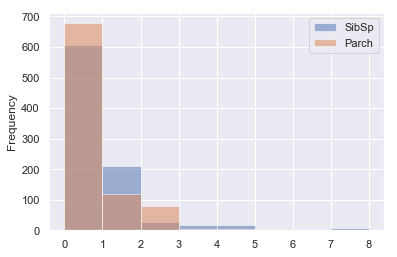

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

explore.drop("Survived",axis=1).plot.hist(alpha=0.5,bins=8)
plt.show()

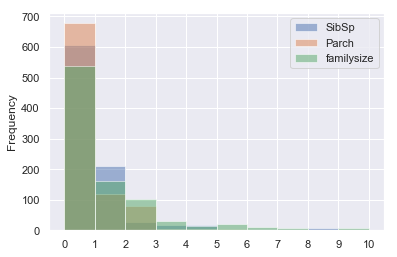

In [118]:
explore["familysize"] = explore[["SibSp","Parch"]].sum(axis=1)
explore.drop("Survived",axis=1).plot.hist(alpha=0.5,bins=10)
plt.xticks(range(11))
plt.show()

<Figure size 432x288 with 0 Axes>

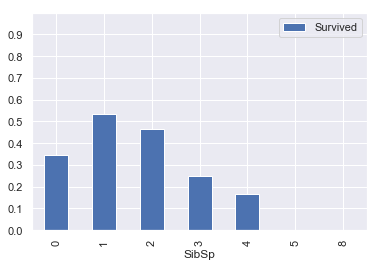

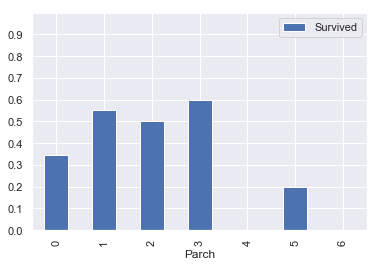

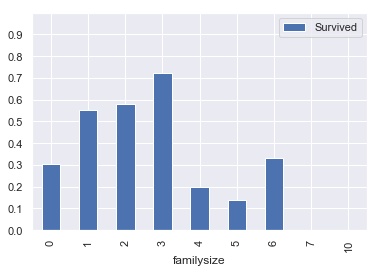

In [119]:
import numpy as np
plt.clf()
for col in explore.columns.drop("Survived"):
    pivot = explore.pivot_table(index=col,values="Survived")
    pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
    plt.show()

The SibSp column shows the number of siblings and/or spouses each passenger had on board, while the Parch columns shows the number of parents or children each passenger had onboard. Neither column has any missing values.

The distribution of values in both columns is skewed right, with the majority of values being zero.

You can sum these two columns to explore the total number of family members each passenger had onboard. The shape of the distribution of values in this case is similar, however there are less values at zero, and the quantity tapers off less rapidly as the values increase.

Looking at the survival rates of the the combined family members, you can see that few of the over 500 passengers with no family members survived, while greater numbers of passengers with family members survived.

# 5 - Engineering New Features


In [120]:
def process_isalone(df):
    df["familysize"] = df[["SibSp","Parch"]].sum(axis=1)
    df["isalone"] = 0
    df.loc[(df["familysize"] == 0),"isalone"] = 1
    #df = df.drop("familysize",axis=1)
    return df

train = process_isalone(train)
holdout = process_isalone(holdout)

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\program files\python36\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

# 6 - Selecting the Best-Performing Features


In [121]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

def select_features(df,index):
    
    # index
    # 0 - random forest
    # 1 - logistic regression
    
    # Remove non-numeric columns, columns that have null values
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(["Survived","PassengerId"],axis=1)
    all_y = df["Survived"]
    
    clf_rf = RandomForestClassifier(random_state=1, n_estimators=100)
    clf_lr = LogisticRegression()
    clfs = [clf_rf,clf_lr]
    
    selector = RFECV(clfs[index],cv=10,n_jobs=-1)
    selector.fit(all_X,all_y)
    
    best_columns = list(all_X.columns[selector.support_])
    print("Best Columns \n"+"-"*12+"\n{}\n".format(best_columns))
    
    return best_columns

cols_rf = select_features(train,0)
cols_lr = select_features(train,1)

Best Columns 
------------
['Pclass', 'Age', 'SibSp', 'Parch', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Child', 'Age_categories_Teenager', 'Age_categories_Young Adult', 'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12', 'Fare_categories_12-50', 'Fare_categories_50-100', 'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'Ticket_A4', 'Ticket_A5', 'Ticket_AS', 'Ticket_C', 'Ticket_CA', 'Ticket_CASOTON', 'Ticket_FC', 'Ticket_FCC', 'Ticket_LINE', 'Ticket_PC', 'Ticket_PP', 'Ticket_PPP', 'Ticket_SC', 'Ticket_SCAH', 'Ticket_SCOW', 'Ticket_SCPARIS', 'Ticket_SCParis', 'Ticket_SOC', 'Ticket_SOP', 'Ticket_SOPP', 'Ticket_SOTONO2', 'Ticket_SOTONOQ', 'Ticket_SP', 'Ticket_STONO', 'Ticket_STONO2', 'Ticket_SWPP', 'Ticket_W

# Reducing Dimensionality with PCA

In [101]:
# Remove string objects
numeric_train = train.drop(train.select_dtypes(['object', 'category']), axis=1)
numeric_train = numeric_train.drop('Survived', axis=1)

numeric_holdout = holdout.drop(holdout.select_dtypes(['object', 'category']), axis=1)
numeric_train.head()

,PassengerId,Pclass,Age,SibSp,Parch,Age_categories_Missing,Age_categories_Infant,Age_categories_Child,Age_categories_Teenager,Age_categories_Young Adult,...,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_X,Pclass_1,Pclass_2,Pclass_3,familysize,isalone
0,1,3,22.0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,1,0
1,2,1,38.0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,3,3,26.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1
3,4,1,35.0,1,0,0,0,0,0,1,...,0,0,0,0,1,1,0,0,1,0
4,5,3,35.0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,1


In [93]:
from sklearn.decomposition import PCA

pca = PCA(n_components=60)

train_modified = pca.fit_transform(numeric_train)

print(pca.explained_variance_ratio_)

print("total components", numeric_train.shape[1])
print("Relevant components", train_modified.shape[1])


[9.95143738e-01 4.72348596e-03 6.25217599e-05 1.84661108e-05
 1.06211982e-05 7.19673291e-06 6.01403337e-06 4.60737333e-06
 3.34539033e-06 2.68108665e-06 2.45778639e-06 1.74097749e-06
 1.41485819e-06 1.33777509e-06 1.17503752e-06 9.98313660e-07
 8.98239117e-07 8.07567301e-07 6.59890865e-07 5.85986717e-07
 5.55264364e-07 5.38385035e-07 4.61272796e-07 4.17366845e-07
 4.09133192e-07 3.05001006e-07 2.72388815e-07 2.32149771e-07
 2.26596042e-07 1.82308036e-07 1.73905274e-07 1.43453778e-07
 1.13114314e-07 1.06381695e-07 9.53305011e-08 8.92336344e-08
 8.89575663e-08 8.61828768e-08 8.00831484e-08 7.33942208e-08
 6.62808752e-08 6.39035013e-08 5.32296563e-08 4.77213136e-08
 4.53756761e-08 3.68750488e-08 3.28880194e-08 3.24437276e-08
 2.59239619e-08 2.08204398e-08 2.04757630e-08 1.82158070e-08
 1.68822917e-08 1.68692695e-08 1.67158275e-08 1.66907293e-08
 1.66280636e-08 1.62983783e-08 1.61782495e-08 1.57301677e-08]
total components 75
Relevant components 60


# 7 - Selecting and Tuning Different Algorithms


In [122]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAgressiveClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import numpy as np

def select_model(df,features):
    
    all_X = df[features]
    all_y = df["Survived"]

    # List of dictionaries, each containing a model name,
    # it's estimator and a dict of hyperparameters
    models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1, 2]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [100, 200],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [10, 20],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 2],
                    "min_samples_split": [2]
                }
        },
        {
            "name":"SVC",
            "estimator":SVC(),
            "hyperparameters":
                {
                  "kernel": ['rbf', 'linear'],  
                  "C": [0.01, 0.1, 1],
                  "gamma": [0.01, 0.1, 1]
                }
        },
        "name": "PassiveAgressiveC",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },
    ]

    for model in models:
        print(model['name'])
        print('-'*len(model['name']))

        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10)
        grid.fit(all_X,all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models

In [123]:
result_a = select_model(train_modified, train['Survived'])

LogisticRegression
------------------
Best Score: 0.8181818181818182
Best Parameters: {'solver': 'newton-cg'}

KNeighborsClassifier
--------------------
Best Score: 0.5353535353535354
Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 19, 'p': 1, 'weights': 'uniform'}

RandomForestClassifier
----------------------


KeyboardInterrupt: 

In [ ]:
result_b = select_model(train,cols_lr)

# 8 - Making a Submission to Kaggle


In [ ]:
def save_submission_file(model, pca_class, filename):
    holdout_data = pca_class.transform(numeric_holdout)
    predictions = model.predict(holdout_data)
    
    holdout_ids = holdout["PassengerId"]
    submission_df = {"PassengerId": holdout_ids,
                 "Survived": predictions}
    submission = pd.DataFrame(submission_df)

    submission.to_csv(filename,index=False)

In [105]:
best_rf_model = result_b[2]["best_model"]
save_submission_file(best_rf_model, pca,"submission_23.csv")

ValueError: Number of features of the model must match the input. Model n_features is 30 and input n_features is 60 

#9 - Next Steps




We encourage you to continue working on this Kaggle competition. Here are some suggestions of next steps:

- Continue to explore the data and create new features, following the workflow and using the functions we created.
- Read more about the titanic and this Kaggle competition to get ideas for new features.
- Use some different algorithms in the select_model() function, like [stochastic gradient descent](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) or [perceptron linear models](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html).
- Experiment with [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) instead of **GridSearchCV** to speed up your **select_features()** function.

Lastly, while the Titanic competition is great for learning about how to approach your first Kaggle competition, we recommend against spending many hours focused on trying to get to the top of the leaderboard. With such a small data set, there is a limit to how good your predictions can be, and your time would be better spent moving onto more complex competitions.

Once you feel like you have a good understanding of the Kaggle workflow, you should look at some other competitions - a great next competition is the [House Prices Competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). A start point you can find [here](https://www.dataquest.io/blog/kaggle-getting-started/).